In [1]:
import re
import random
import pandas as pd
import hashlib

In [2]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [3]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Node.JS and React,232.233226,7.491394,13.134159,31
"Mexican Gothic, Moreno-Garcia",661.699479,23.632124,38.563817,28
Azure Functions Core Tools,482.876514,28.404501,43.368044,17
Node.js and Vite,1893.237387,46.176522,70.834512,41
Django,1848.194986,46.204875,64.836515,40
Python,4179.589899,53.584486,167.267674,78
VMWare,57.211859,57.211859,57.211859,1
Azure Files Documentation,3538.860602,58.981010,152.922022,60
Active Directory and Azure Files,2436.468663,65.850504,109.483390,37
CCH Tax Forms Project,1390.807160,66.228912,140.166819,21


# Histogram

sum of ages: ~51728.79


<Axes: >

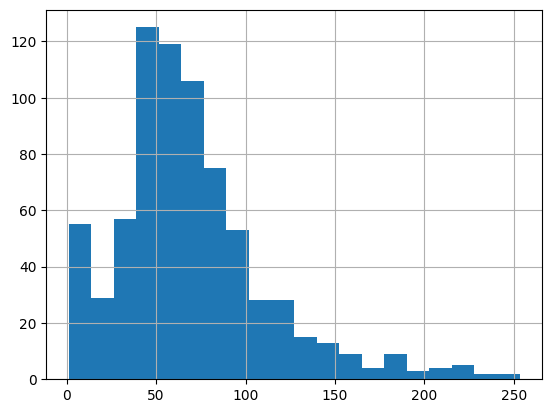

In [4]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~51728.79


<Axes: >

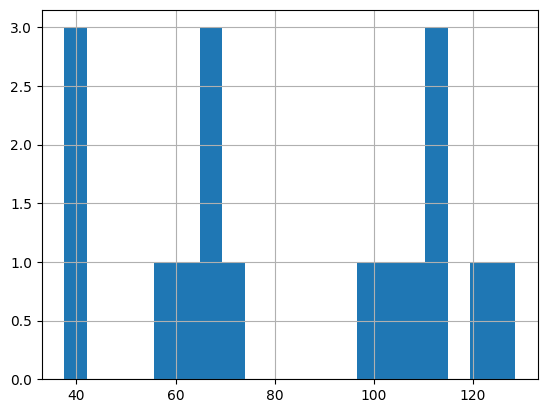

In [5]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Asynchronous Python']['age'].hist(bins=20)

# Completely Random Shuffle

In [6]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [7]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [8]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [9]:
n=3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n

existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

Cards found: 741
Total card age: 51728.79


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
207,Azure VM + Developer,X11 Forwarding\nAn SSH technique that lets GUI...,0541a216239d45b4dd18aaea19bd5712,-186.873812,-103.015685,186.873812,1339.203902,0.989398,13,0,0
208,Azure VM + Developer,Debugger Config (launch.json)\nA JSON config f...,dcbec62ebe0fd2c7081c6a742624e2c7,-118.415881,-103.015685,186.873812,1339.203902,0.989398,13,3,0
209,Azure VM + Developer,Debug Adapter Protocol\nA VS Code protocol tha...,6a90ea3b3e03a7a341e1227b67bf7f7d,-91.446572,-103.015685,186.873812,1339.203902,0.989398,13,6,0
210,Azure VM + Developer,SSH Config File\nA local file (`~/.ssh/config`...,9e97724f57d5061c3baabe7364aab11b,-83.215402,-103.015685,186.873812,1339.203902,0.989398,13,9,0
211,Azure VM + Developer,Test Pyramid\nA testing strategy that favors m...,304a7c285662cd3d8acb09c2b8774c30,-39.922177,-103.015685,186.873812,1339.203902,0.989398,13,12,0
91,PnP PowerShell,App-Only Authentication\nA mode where applicat...,12d9bc97a1e6f53d3b7295eb85274bad,-246.469948,-100.978168,246.469948,3433.257716,0.453929,34,0,0
92,PnP PowerShell,Remove-PnPListItem (PnP.PowerShell)\nDeletes a...,9fa10ff7ee6242fda9842362d897ec9e,-189.408017,-100.978168,246.469948,3433.257716,0.453929,34,3,0
597,PnP PowerShell,Connect-PnPOnline (PnP.PowerShell)\nEstablishe...,874a3f0f70df8de5e68fa8b5f2ba77b1,-136.809816,-100.978168,246.469948,3433.257716,0.453929,34,6,0
94,PnP PowerShell,PowerShell Pipeline\nA feature that allows the...,9a180efe01de21f30191a85290e58476,-109.252105,-100.978168,246.469948,3433.257716,0.453929,34,9,0
599,PnP PowerShell,SharePoint Site URL\nThe web address of a Shar...,04244872161db0e76bd9f26ea84f1074,-92.087367,-100.978168,246.469948,3433.257716,0.453929,34,12,0


## Age Max

In [10]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [11]:
# n=5
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [12]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [13]:
existing_cards.head(10)['age'].sum()

np.float64(-1293.9010964514703)

In [14]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
55,Terraform Codebox,A cloud-init.yaml.tpl file is a template for p...,e86be4b765ffee839b385a1a96ac3db1,-253.190448,-92.218416,253.190448,4334.265534,0.509520,47,0,0
91,PnP PowerShell,App-Only Authentication\nA mode where applicat...,12d9bc97a1e6f53d3b7295eb85274bad,-246.469948,-100.978168,246.469948,3433.257716,0.453929,34,0,0
103,Power BI,Why can’t you reference a newly added column a...,a550364578e3469f2990bdec6904efc0,-240.522282,-89.988958,240.522282,2879.646646,0.585606,32,0,0
313,Terraform Codebox,Azure Files can be used to persist your coding...,9775a34a34e3610d8ddc43c1e0b44268,-232.209569,-92.218416,253.190448,4334.265534,0.509520,47,1,1
349,PnP PowerShell,Environment Variables\nVariables that are set ...,e888c7c4c00e3b122457c3d900fd4e77,-223.919736,-100.978168,246.469948,3433.257716,0.453929,34,1,1
38,JavaScript Concepts,Generate distinct arrays with fill() + map()\n...,1c477652c74da3a626b132108ec4229f,-221.713627,-91.725601,221.713627,4586.280053,0.378510,50,0,0
173,Azure Compute Gallery,"Managed Image – A single, region-bound image s...",4099811ce9ab63014bfbe9d3999b3e32,-221.278155,-100.790043,221.278155,1814.220771,0.924703,18,0,0
596,PnP PowerShell,REST API Endpoints\nSpecific URLs used to acce...,b12f5012328f32a6c689485970705806,-218.845961,-100.978168,246.469948,3433.257716,0.453929,34,2,2
127,Vocab,Anacoluthon\nnoun\nSPA: an-uh-koh-LOO-thon\nIP...,58fe2f5c535300af7c826eb1cff7d208,-215.644997,-92.551901,215.644997,2313.797533,0.449155,25,0,0
22,Microsoft Purview,Define what each label can do. Configure the p...,2314da7a2bfdaa36bc1e3f2e5633935f,-209.742770,-100.636551,209.742770,4830.554443,0.423208,48,0,0


In [15]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 69.809'